In [65]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
from clean_data_2 import *

import plotly.express as px

#### Frame the Problem


This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

Cleaning
This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

Final Advice
Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### Desired Result

The desired result will be an app that will filter offers based on the selected demographics by the user. The app is to be used by starbuck's marketing department to select the right offer for the right demographic. 

In this jupyter notebook we will explore the nuances of our data and understand the different aspects of customers, offers, and transactions

In [66]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

#### Import data

In [67]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [68]:
portfolio = clean_portfolio(portfolio)

In [69]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [70]:
profile = clean_profile(profile)

In [71]:
profile.head()

,gender,age,customer_id,became_member_on,income,valid,gender_F,gender_M,gender_O
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,0


In [72]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [73]:
transcript = clean_transcript(transcript)

In [74]:
transcript 

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,0,0,0,1,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,0,0,0,1,None,9.53
306531,a00058cf10334a308c68e7631c529907,714,0,0,0,1,None,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,0,0,0,1,None,3.53


In [75]:
df = merge_datasets(portfolio, profile, transcript)

In [76]:
df

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,gender,age,...,gender_M,gender_O,reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,B3,NaN,F,75,...,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,D1,NaN,None,118,...,0,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,D4,NaN,M,68,...,1,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,D3,NaN,None,118,...,0,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,B2,NaN,None,118,...,0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,0,0,0,1,None,1.59,M,66,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,0,0,0,1,None,9.53,M,52,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,714,0,0,0,1,None,3.61,F,63,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,0,0,0,1,None,3.53,M,57,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis of our data set

our dataset has 306,534 rows. These rows combine event and offer data in a single dataset to make it easier for analysis 

In [77]:
df.shape

(306534, 24)

### Story of 1 customer 

Below we see the story of 1 customer, the behaviour of a customer for the duration of the test. Time 0 indicates the start of the test and the last row is the last event that happened. We have randomly chosen a customer at the age of 75 that has received multiple offer and we have a historic view of how she responded. Ideally we want to replicate that pythonically for every customer

In [78]:
df[df.customer_id =='78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,gender,age,...,gender_M,gender_O,reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,B3,NaN,F,75,...,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
15561,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,B3,NaN,F,75,...,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
47582,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,19.89,F,75,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,B3,NaN,F,75,...,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
49502,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,17.78,F,75,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,168,0,1,0,0,I2,NaN,F,75,...,0,0,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0
85291,78afa995795e4d85b5d9ceeca43f5fef,216,0,0,1,0,I2,NaN,F,75,...,0,0,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0
87134,78afa995795e4d85b5d9ceeca43f5fef,222,0,0,0,1,None,19.67,F,75,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,240,0,0,0,1,None,29.72,F,75,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,378,0,0,0,1,None,23.93,F,75,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the below table we see the behaviour of our selected customer for one specific offer. We can see that the offer was succesful

In [79]:
df[(df.offer_id=='B3') & (df.customer_id=='78afa995795e4d85b5d9ceeca43f5fef')]

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,gender,age,...,gender_M,gender_O,reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,B3,NaN,F,75,...,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
15561,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,B3,NaN,F,75,...,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
47583,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,B3,NaN,F,75,...,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0


#### Which offers get completed more 

Text(0.5, 1.0, 'Offer type received')

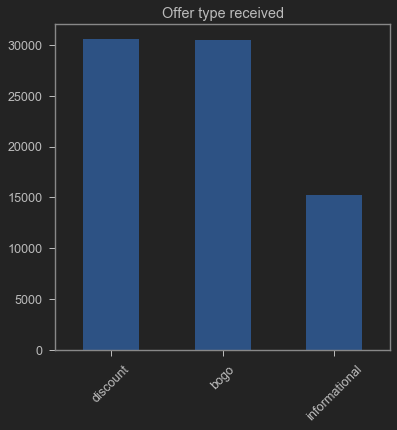

In [80]:
df[df.event_offer_received == 1].offer_type.value_counts().plot(kind='bar', rot=45, figsize=(6,6), alpha=0.6)
plt.title('Offer type received')

#### What is the distribution of the amount people are spending on a transaction

Text(0.5, 1.0, 'Average Spend')

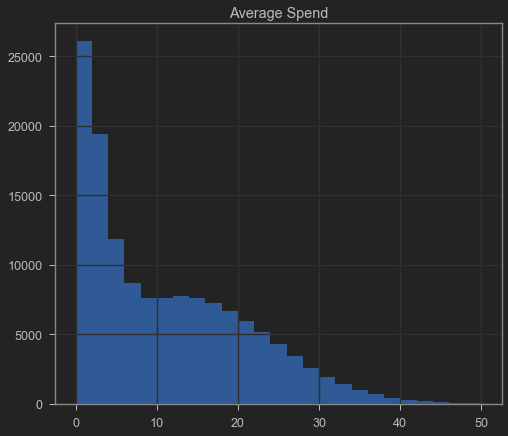

In [81]:
df.amount.hist(bins = 25, range=[0, 50], alpha = 0.7)
plt.title('Average Spend')

#### What is the income distribution in our dataset ?

Text(0.5, 1.0, 'Income Distribution')

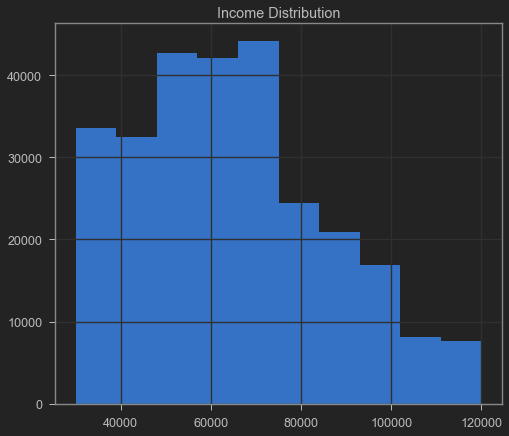

In [82]:
df.income.hist()
plt.title('Income Distribution')

#### Is there a correlation between amount spent and income? 

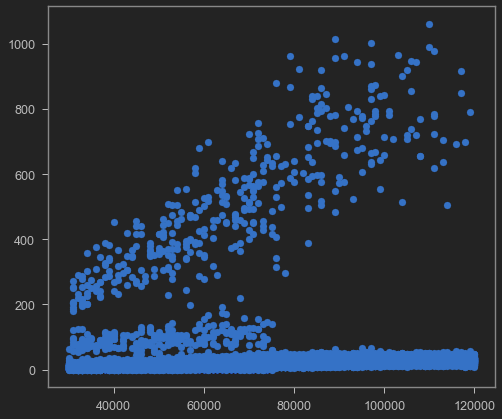

In [83]:
plt.scatter(x='income', y='amount',data=df)

In [84]:
df_amount = df[df.amount > 200]

In [85]:
px.scatter(df_amount,x='income', y='amount',)

In [91]:
customers = per_customer_data(df, profile)

In [92]:
customers

,total_expense,total_transactions,received,viewed,completed,reward,bogo_received,bogo_viewed,bogo_completed,bogo_reward,...,age,became_member_on,income,valid,gender_F,gender_M,gender_O,age_group,income_group,net_expense
0009655768c64bdeb2e877511632db8f,127.60,8.0,5.0,4.0,3.0,9.0,1.0,1.0,1.0,5.0,...,33,2017-04-21,72000.0,1,0,1,0,25,70000,118.60
00116118485d4dfda04fdbaba9a87b5c,4.09,3.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,...,118,2018-04-25,NaN,0,0,0,0,0,0,4.09
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0,5.0,5.0,3.0,13.0,1.0,1.0,1.0,5.0,...,40,2018-01-09,57000.0,1,0,0,1,35,50000,66.46
0020c2b971eb4e9188eac86d93036a77,196.86,8.0,5.0,3.0,3.0,14.0,2.0,1.0,1.0,10.0,...,59,2016-03-04,90000.0,1,1,0,0,55,90000,182.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0,4.0,4.0,3.0,13.0,2.0,2.0,2.0,10.0,...,24,2016-11-11,60000.0,1,1,0,0,15,60000,141.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff8bb9517a1e4ef18b63eb9f2ba67d9e,0.00,0.0,5.0,5.0,0.0,0.0,2.0,2.0,0.0,0.0,...,54,2018-01-18,85000.0,1,1,0,0,45,80000,0.00
ff8bee9ba3754ac687d9af685b2981b7,0.00,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,64,2018-05-31,72000.0,1,0,1,0,55,70000,0.00
ffc6c9fbe34b4578911dcdf6745b4c74,0.00,0.0,3.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,...,62,2018-04-10,57000.0,1,1,0,0,55,50000,0.00
ffd810f301ad42d6bfe98c4ba6ee4125,0.00,0.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,...,65,2018-02-15,52000.0,1,0,1,0,65,50000,0.00


#### Does income group has a releationship with the total expense of a customer ? 

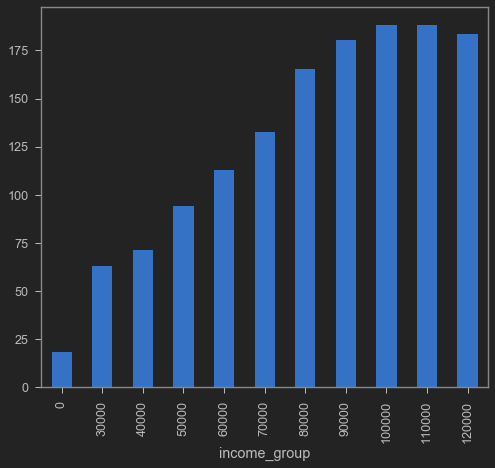

In [150]:
customers.groupby('income_group')['total_expense'].mean().plot(kind='bar')

#### Does age group has an effect on total expense ? 

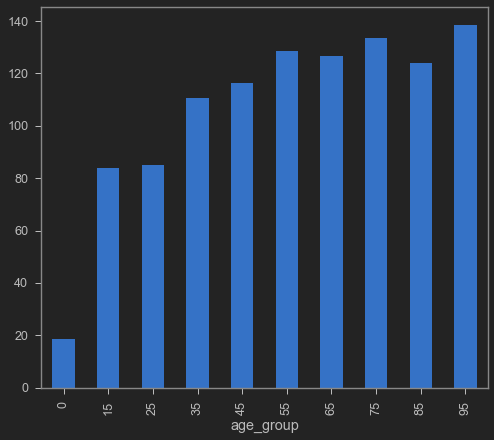

In [94]:
customers.groupby('age_group')['total_expense'].mean().plot(kind='bar')

#### Does gender affect total expense ? 

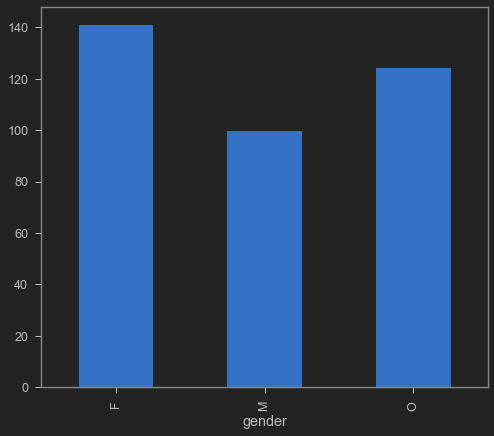

In [95]:
customers.groupby('gender')['total_expense'].mean().plot(kind='bar')

#### Initial conclusion from the analysis

Gender, age, and inc